<h1 style="text-align: center;">Проект для «Викишоп»</h1>

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Необходимо обучить модель классифицировать комментарии на позитивные и негативные. Имеется набор данных с разметкой о токсичности правок.

Необходимая метрика качества **F1 >= 0.75**. 

# Описание данных

Признак   | Значение
----------|---------
text      | текст комментария
**toxic** | токсичный ли комментарий (целевой признак)

# Импорт необходимых библиотек

In [1]:
pip install -q --upgrade scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install -q torch

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install -q transformers

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install -q tqdm

Note: you may need to restart the kernel to use updated packages.


In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

from sklearn.metrics import f1_score
from sklearn.model_selection import RandomizedSearchCV

# импортируем модель
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.inspection import permutation_importance

import nltk
from nltk.corpus import stopwords as nltk_stopwords
from tqdm import notebook
import torch
import transformers

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import PassiveAggressiveClassifier

from tqdm import tqdm
import re 
from nltk.stem import WordNetLemmatizer
from scipy import sparse
from sklearn.base import BaseEstimator, TransformerMixin

import nltk
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import wordnet

tqdm.pandas()

from sklearn.metrics import precision_recall_curve
from numpy import argmax
from matplotlib import pyplot

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


## Константы

In [6]:
RANDOM_STATE = 42
TEST_SIZE = 0.4

# Загрузка данных

In [7]:
try:

    df = pd.read_csv('./datasets/toxic_comments.csv', index_col=0)

except:
    df = pd.read_csv('/datasets/toxic_comments.csv', index_col=0)

    
<div class="alert alert-success">
<font size="5"><b>Комментарий ревьюера</b></font>

    
Успех:    
    

- Здорово Что знаешь его возможности index_col=0



- молодец что используешь конструкцию try - except (if - else), этим ты проявляешь уважение к тем кто будет работать с твоим кодом.

    

In [8]:
df.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


Данные успешно загружены, пропусков не наблюдается. Для экономии памяти переведём тип данных признака toxic в тип int32.

In [10]:
df['toxic'] = df['toxic'].astype('int32')

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int32 
dtypes: int32(1), object(1)
memory usage: 3.0+ MB


# Предобработка данных

In [12]:
df['toxic'].value_counts()

0    143106
1     16186
Name: toxic, dtype: int64

Почистим текст от всего лишнего и проведём лемматизацию.

In [14]:
lemmatizer = WordNetLemmatizer()


def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)


def lemm_(text):

    lemmatized_output = ' '.join([lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in nltk.word_tokenize(text)])     
    return lemmatized_output    


def clear_text(text):
    r = re.sub(r'[^a-zA-Z]', ' ', text).split()
    return ' '.join(r)

In [15]:
# проверим. создадим датафрейм из двух строк:
print('было')
sentence1 = "The striped bats are hanging on their feet for best"
sentence2 = "you should be ashamed of yourself went worked"
df_my = pd.DataFrame([sentence1, sentence2])

print(df_my)


print('стало после лемматизации')
# и попробуем нашу функцию c помощью apply
print(df_my[0].apply(lemm_))

было
                                                   0
0  The striped bats are hanging on their feet for...
1      you should be ashamed of yourself went worked
стало после лемматизации
0    The strip bat be hang on their foot for best
1       you should be ashamed of yourself go work
Name: 0, dtype: object


In [16]:
%%time
df['corpus'] = df['text'].apply(clear_text)

CPU times: user 4.04 s, sys: 59.6 ms, total: 4.1 s
Wall time: 4.11 s


In [17]:
%%time
df['corpus'] = df['corpus'].progress_apply(lemm_)

100%|██████████| 159292/159292 [19:55<00:00, 133.29it/s]

CPU times: user 18min, sys: 1min 36s, total: 19min 37s
Wall time: 19min 55s


Подготовим пайплайн с предобработкой данных, который будет переводить текст в векторный вид.

In [19]:
vectorizer_pipe = Pipeline(
    [
        (
            'TfidfVectorizer', 
            TfidfVectorizer(stop_words='english', lowercase=True)
        )
    ]
)

In [20]:
data_preprocessor = ColumnTransformer(
    [
        ('vectorizer', vectorizer_pipe, 'corpus'),
    ], 
    remainder='passthrough'
)

Разобьем данные на тренировочную и тестовую выборки. Обязательно добавим стратификацию, чтобы учесть дисбаланс классов.

In [21]:
X = pd.DataFrame(df['corpus'])
y = df['toxic']

X_train, X_valid_test, y_train, y_valid_test = train_test_split(
    X, y, 
    test_size=TEST_SIZE, 
    random_state=RANDOM_STATE,
    stratify=y
)

X_valid, X_test, y_valid, y_test = train_test_split(
    X_valid_test, y_valid_test, 
    test_size=0.5, 
    random_state=RANDOM_STATE,
    stratify=y_valid_test
)

# Обучение моделей

Используем RandomizedSearchCV для обучения и поиска наилучшей модели. В качестве метрики качества используем f1-weighted, так как у нас наблюдается явный дисбаланс классов. Обучим несколько моделей: KNeighborsClassifier, DecisionTreeClassifier, LogisticRegression.

In [23]:
pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', LogisticRegression(n_jobs=-1, random_state=RANDOM_STATE))
    ]
)

In [24]:
param_distributions = [
    {
        'models': [LogisticRegression(n_jobs=-1, random_state=RANDOM_STATE)],
        'models__C': range(1, 20)
    },
    {
        'models': [PassiveAggressiveClassifier(random_state=RANDOM_STATE)],
        'models__max_iter': range(2, 100)
    }
]

In [25]:
# задаём случайный поиск
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_distributions=param_distributions, 
    scoring='f1', 
    random_state=RANDOM_STATE,
    n_jobs=-1
)

In [26]:
%%time
randomized_search.fit(X_train, y_train)

/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_grad

CPU times: user 6min 52s, sys: 2min 41s, total: 9min 34s
Wall time: 9min 34s


RandomizedSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('vectorizer',
                                                                               Pipeline(steps=[('TfidfVectorizer',
                                                                                                TfidfVectorizer(stop_words='english'))]),
                                                                               'corpus')])),
                                             ('models',
                                              LogisticRegression(n_jobs=-1,
                                                                 random_state=42))]),
                   n_jobs=-1,
                   param_distributions=[{'models': [LogisticRegression(n_jobs=-1,
                                                                       random_state=42)],
                                         'models__C': range(1, 20)},
                                        {'models': [PassiveAggressiveClassifier(random_state=42)],
                                         'models__max_iter': range(2, 100)}],
                   random_state=42, scoring='f1')

In [27]:
best_model = randomized_search.best_estimator_

print('Лучшая модель и её параметры:\n\n', best_model)
print ('Метрика лучшей модели на тренировочной выборке:', randomized_search.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('vectorizer',
                                                  Pipeline(steps=[('TfidfVectorizer',
                                                                   TfidfVectorizer(stop_words='english'))]),
                                                  'corpus')])),
                ('models',
                 LogisticRegression(C=12, n_jobs=-1, random_state=42))])
Метрика лучшей модели на тренировочной выборке: 0.77051007220364


Получили лучшую модель: DecisionTreeClassifier. Метрика качества на тренировочной выборке отличная. Посмотрим на метрику качества лучшей моделе на тестовой выборке.

In [28]:
preds = best_model.predict(X_valid)

score = f1_score(y_valid, preds)
print ('Метрика лучшей модели на валидационной выборке:', score)

Метрика лучшей модели на валидационной выборке: 0.7739293635898311


Попробуем подобрать наилучший порог предсказаний.

Best Threshold=0.388412, F-Score=0.781


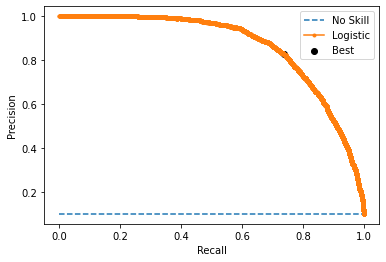

In [29]:
yhat = best_model.predict_proba(X_valid)
# keep probabilities for the positive outcome only
yhat = yhat[:, 1]
# calculate roc curves
precision, recall, thresholds = precision_recall_curve(y_valid, yhat)
# convert to f score
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))
# plot the roc curve for the model
no_skill = len(y_valid[y_valid==1]) / len(y_valid)
pyplot.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
pyplot.plot(recall, precision, marker='.', label='Logistic')
pyplot.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
pyplot.legend()
# show the plot
pyplot.show()

Метрика качества на валидационной выборке 0.78. Посмотрим на метрику качества на тестовой выборке.

In [33]:
preds_test = (best_model.predict_proba(X_test)[:,1] >= 0.388412).astype(bool)
#preds_test = best_model.predict(X_test)

score = f1_score(y_test, preds_test)
print ('Метрика лучшей модели на тестовой выборке:', score)

Метрика лучшей модели на тестовой выборке: 0.7742363877822045


## Анализ важности признаков

Оценим важность признаков для лучшей модели.

In [31]:
feature_names = best_model.steps[0][1]['vectorizer'].get_feature_names_out()

In [34]:
# сформируем таблицу важности признаков
feature_importances = pd.DataFrame(
    {
        'Feature': feature_names,
        'Importance': pd.Series(best_model.steps[1][1].coef_[0])
    })

# сортируем таблицу по важности — от большей к меньшей и выводим первые 10
print(feature_importances.sort_values('Importance', ascending=False)[:10])

        Feature  Importance
39100      fuck   32.883658
93465      shit   21.040695
11784     bitch   20.395680
48452     idiot   19.651766
7012    asshole   19.393710
39129   fucking   19.256757
98929    stupid   17.804716
14655  bullshit   17.421052
99360      suck   17.102801
35462    faggot   16.824383


Модель выделяет самый важный признак слово "fuck". Отмечаем, что ни один признак не является единственно важным, что означает, что модель работает корректно.

# Общие выводы

Лучшая модель: **LogisticRegression**

Параметры модели: **n_jobs=-1, C=12**

Метрика качества на тестовой выборке: **f1 = 0.77**